# Missing values techniques

### Autor: Silvia García Hernández                                                                    
### Fecha: 31/03/2019

Testing different methods of missing values. A classification using decision tree is implemented.

### Importación de librerías 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn import linear_model, metrics
from sklearn.model_selection  import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor

### Lectura y visualización del dataset

In [2]:
datos_original = pd.read_csv("winequality-white.csv", sep = ";")    # Lectura archivo .csv
                                                                   
nmuestras = len(datos_original)                                     # Número de muestras
natributos = datos_original.columns.size                            # Número de atributos

datos_original.head()                                               # Impresión de cabecera

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### Incorporación de los Valores Perdidos
##### Una vez leído el dataset en cuestión, se va a preparar el proceso para crear los conjuntos de datos sobre los que se va a trabajar, esto es, los conjuntos de datos que posean un cierto porcentaje de valores perdidos. Para ello, y primeramente, se va a crear una matriz 3D donde se almacenarán los dataset con 5,10,15,20,25 y 30% (6 datasets) de valores perdidos (missing values), que se puede observar en el siguiente paso:

In [3]:
# Se recorren los 6xdatasets aplicando la regla de la cantidad de valores perdidos para fijar a NaN ciertos datos.

nrandom = np.linspace(0.05, 0.3, num = 6)
numIter = len(nrandom)
dataMissingValues = []

for k in nrandom:
    datos = np.copy(datos_original)
    
    for i in range(nmuestras):
        for j in range(natributos-1):
            rnd = np.random.rand()
            if rnd < k:
                datos[i,j] = np.nan
                                                                    
    dataMissingValues.append(datos)                                 # 'dataMissingValues' es una lista con cada dataset
                                                                    
allMissingValues = np.stack(dataMissingValues)                      # Se añade cada dataset a 'allMissingValues' y se 
allMissingValues.shape                                              # convierte a ndarray

(6, 4898, 12)

#### La matriz 'allMissingValues' contiene todos los valores perdidos de los 6 datasets

### Entrenamiento
##### Una vez hecho lo anterior, se van a entrenar 6x11 árboles de regresión. Como este método no acepta los valores NaN, se van a eliminar todas las muestras (filas) que contienen alguno en cualquier atributo y, con ello, se va a entrenar, por columnas, cada árbol. En otras palabras, si se quiere entrenar el árbol de regresión para estimar los valores de la primera columna del primer dataset, las entradas (o X) serán el resto de atributos del dataset (a excepción de la clase 'quality'), mientras que la salida (o Y) será la columna en cuestión. Esto se va a llevar a cabo con cada característica en cada dataset.

In [4]:
allTreeRegressors = []

for numFrame in range(numIter):
    for col in range(natributos-1):
        entradas = list(range(0, 11))
        del entradas[col]
                                                                    
        with_missing_values = np.copy(allMissingValues[numFrame])   # Copia de un dataset
        data_without_missing_values = with_missing_values[~np.isnan(with_missing_values).any(axis = 1)]
                                                                    # Eliminación de todas las muestras que contienen NaN
        tree = DecisionTreeRegressor(max_depth=10)                  # Definición de árbol de regresión
        
        X = data_without_missing_values[:,entradas]                 # Entradas del árbol de regresión 
        Y = data_without_missing_values[:,col]                      # Salida del árbol de regresión
        
        treeRegressor = tree.fit(X, Y)                              # Entrenamiento
        allTreeRegressors.append(treeRegressor)

allTreeRegressorss = [allTreeRegressors[i:i+(natributos-1)] for i in range(0, len(allTreeRegressors), natributos-1)]
#print(allTreeRegressorss)
len(allTreeRegressorss[1])

11

#### La lista 'allTreeRegressors' contiene todos los árboles de regresión de los 6 datasets

### Visualización de árboles de regresión

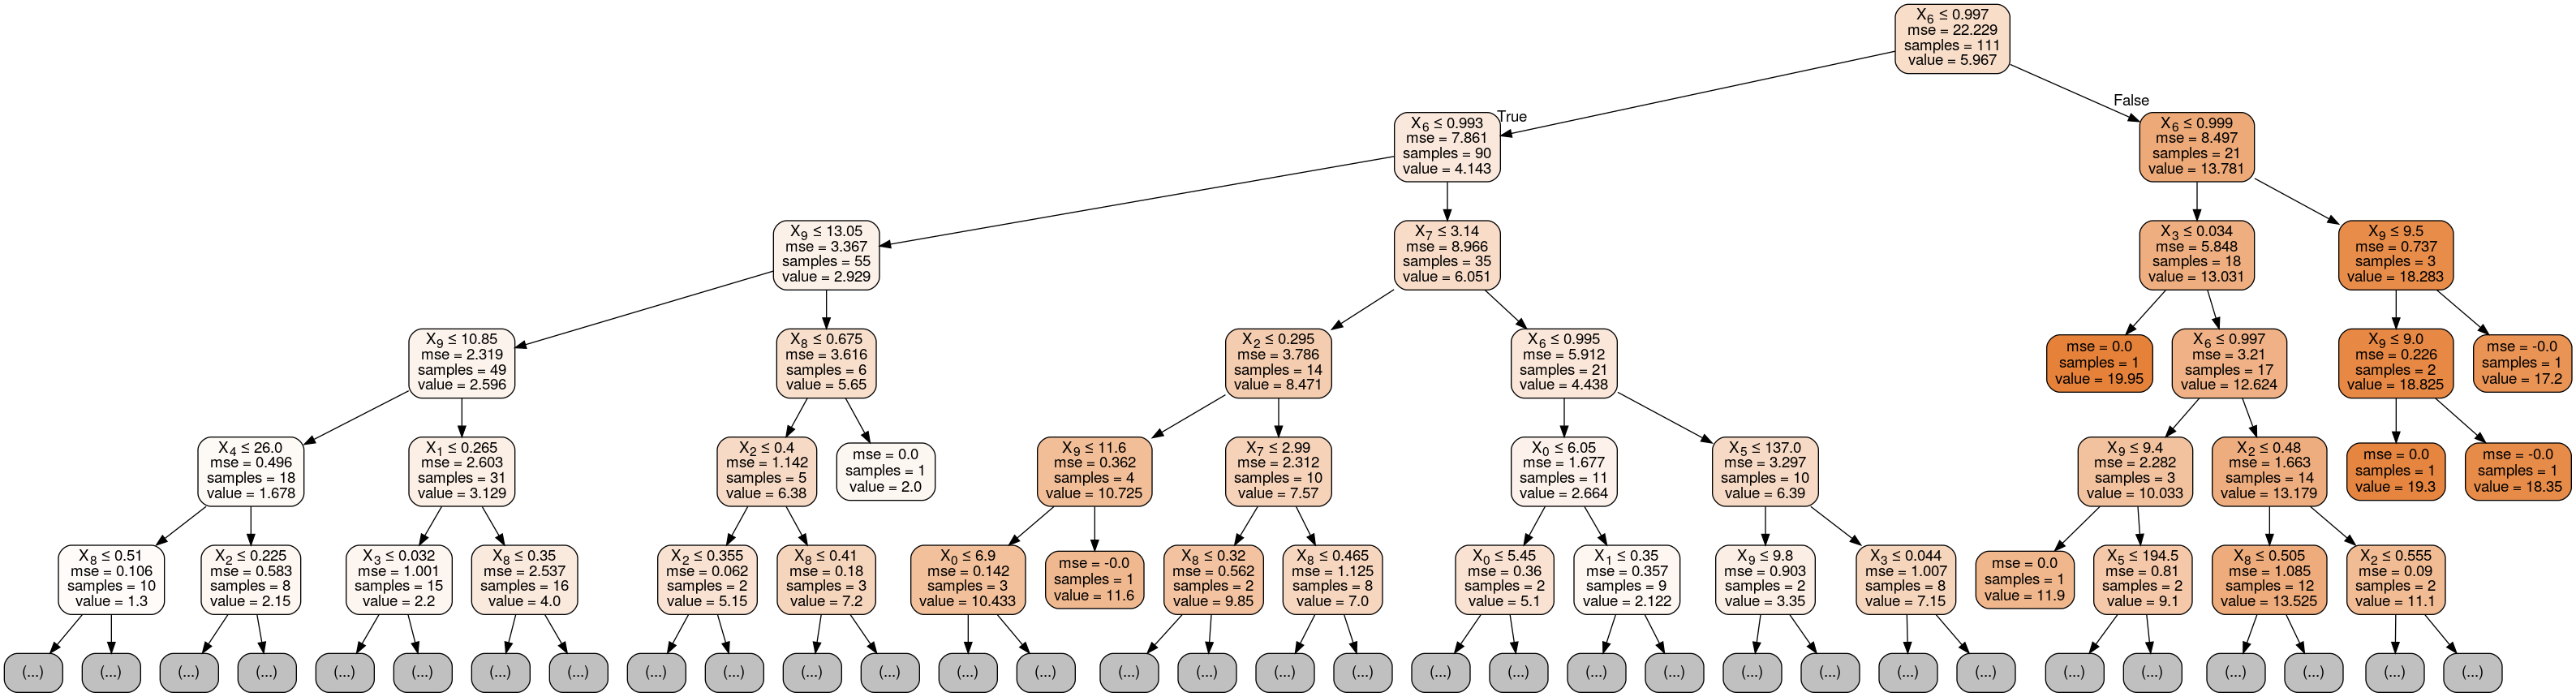

In [5]:
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(allTreeRegressorss[5][3], out_file=dot_data, max_depth=5,
filled = True, rounded = True,
special_characters = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

### Cálculo de las medias por atributo (columna) y sustitución en cada dataset 
##### Para entrenar los 6x11 árboles de regresión solo ha hecho falta eliminar todas las muestras (filas) que poseyeran algún valor NaN, pero para el caso de estimar dichos valores NaN con el método asignado (y debido a que no acepta valores no definidos), no es tan fácil. Lo que se ha hecho es calcular la media por atributo para sustituir este valor obtenido en todos los datos puestos a NaN y que, de esta forma, sea posible estimar los valores perdidos de cualquier columna.

In [6]:
meanData = []

for numFrame in range(numIter):
    
    with_missing_values = np.copy(allMissingValues[numFrame])       # Copia de un dataset
            
    for col in range(natributos-1):
                                                                    # Eliminación de valores perdidos por columna 
        data_without_missing_values = with_missing_values[~np.isnan(with_missing_values[:,col])]
        meanCol = data_without_missing_values[:,col].mean()         # Cálculo de la media por atributo
            
        for row in range(nmuestras):
            if np.isnan(with_missing_values[row][col]):
                with_missing_values[row][col] = meanCol             # Asignación de la media al valor perdido
                                                                    
    meanData.append(with_missing_values)                            # Incorporación de un dataset con los valores 
                                                                    # perdidos sustituidos por la media a meanData
allMeanData = np.stack(meanData)                                    # Anexión de cada dataset en 'allMeanData'
allMeanData.shape

(6, 4898, 12)

#### La matriz 'allMeanData' contiene todos los valores perdidos sustituidos por la media del atributo en los 6 datasets

### Estimación de valores perdidos con el método asignado (árbol de regresión)
##### Una vez se han calculado las matrices 'allMissingValues' y 'allMeanData' se puede proceder a la estimación de los valores perdidos de cada dataset. El procedimiento consiste en utilizar la matriz 'allMeanData' de tal forma que se sustituya la columna en cuestión por su correspondiente en la matriz 'allMissingValues' y, una vez hecho esto, se eliminen todas las muestras (filas) que no poseen un valor perdido en el atributo tratado. La salida de esto será un dataset donde la columna que se quiere estimar estará toda a NaN y el resto de atributos consistirán en el resto de datos de las muestras a tratar, los cuales pueden ser o los reales o la media estimada.
##### Una vez predichos los valores perdidos, restaría introducirlos en la matriz final, la cual únicamente poseerá valores reales o estimados por el árbol de regresión.

In [7]:
datos_estimados_y_reales = np.copy(allMeanData)

for numFrame in range(numIter):
    
    with_missing_values = np.copy(allMissingValues[numFrame])
                                                                    
    for col in range(natributos-1):
        entradas = list(range(0, 11))
        del entradas[col]
        unnecesary = np.copy(allMeanData[numFrame])                 # Se crea una matriz idéntica a 'allMeanData'
        
        unnecesary[:,col] = with_missing_values[:,col]              # Se sustituye 'col' por su homónima con valores NaN 
        unnecesary = unnecesary[np.isnan(unnecesary[:,col])]        # Se eliminan las muestras que no contienen NaN
        
        temp = allTreeRegressorss[numFrame][col].predict(unnecesary[:,entradas])
                                                                    # Se estiman los valores NaN de 'col' 
        for n in range(len(temp)):
            ind = np.argwhere(np.isnan(allMissingValues[numFrame][:,col]))[n]
            datos_estimados_y_reales[numFrame][ind,col] = temp[n]   # Se sustituyen los valores NaN por los estimados
            
datos_estimados_y_reales.shape

(6, 4898, 12)

#### La matriz 'datos_estimados_y_reales' contiene todos los valores estimados en los 6 datasets

### Cálculo del RMSE por atributo en cada dataset
##### A continuación se calcula la raíz del error cuadrático medio para cada atributo en los 6 datasets, esto es, se aplica RMSE a la matriz de salida anterior 'datos_estimados_y_reales'. La función necesita como entradas la columna en cuestión del dataset sin modificar y la misma columna de la matriz estimada por el árbol de regresión, de tal forma que pueda calcular la desviación cuadrática media del atributo.

In [8]:
datosN = np.copy(datos_original)
datos_null = [np.isnan(numFrame) for numFrame in allMissingValues]

RMSE = []

for numFrame in range(numIter):
    RMSE_values = []
    for col in range(natributos-1):
                                                                    
        ind = np.where(datos_null[numFrame][:,col])[0]              # Localización de índices con valores perdidos
        y_real = datosN[ind,col]                                    # Valores reales en las localizaciones anteriores
        y_estimada = datos_estimados_y_reales[numFrame][ind,col]    # Valores estimados en las localizaciones anteriores

        RMSE_values.append(np.sqrt(metrics.mean_squared_error(y_real, y_estimada)))
                                                                    # Cálculo de RMSE
    RMSE.append(RMSE_values)
    
RMSE = np.array(RMSE)
RMSE.shape

(6, 11)

#### La matriz 'RMSE' contiene todos los errores por atributo de los 6 datasets

### Visualización del RMSE por dataset
##### Se va a visualizar, por ejemplo, el RMSE según del primer dataset

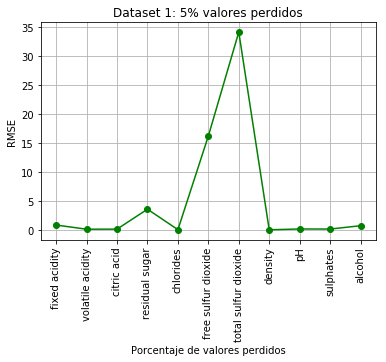

In [9]:
nrandom = np.linspace(0.05, 0.3, num = 11)
nom_col = []

for w in range(11):
    datos_original_atributos = datos_original.columns[w]
    nom_col.append(datos_original_atributos)

figRMSEdata = plt.figure()
plt.title("Dataset 1: 5% valores perdidos")
plt.plot(nom_col, RMSE[1,:], 'go-')
plt.xticks(rotation = 90)
plt.xlabel("Porcentaje de valores perdidos")
plt.ylabel("RMSE")
plt.grid()

In [10]:
nom_col

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

### Entrenamiento y estimación con SVM de datos reales
##### Ahora se va a entrenar la Máquina de Soporte Virtual con los datos reales del archivo .csv. Se va a usar de entradas todas las características de las muestras y la salida será la categoría de las mismas. Como muestras de entrenamiento se ha usado un 60% del dataset, mientras que de test se tiene un 40% de las mismas.

In [20]:
datosN = np.copy(datos_original)

X = datosN[:,:-1]
Y = datosN[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4, random_state = 42)

svc = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
resultado_base = metrics.accuracy_score(y_pred, y_test) 

resultado_base

0.551530612244898

### Entrenamiento y estimación con SVM de datos estimados
##### Por último, se va a realizar lo mismo que en el paso anterior pero para cada uno de los datasets obtenidos con diferentes porcentajes de valores perdidos y estimados.

In [21]:
resultados = []

for numFrame in range(numIter):
    X = datos_estimados_y_reales[numFrame][:,:-1]
    Y = datos_estimados_y_reales[numFrame][:,-1]

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4, random_state = 42)

    svc = SVC(gamma = "auto")
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    resultados.append(metrics.accuracy_score(y_pred, y_test))
    
resultados

[0.5418367346938775,
 0.5153061224489796,
 0.5127551020408163,
 0.4806122448979592,
 0.48775510204081635,
 0.46122448979591835]

#### La matriz 'resultados' contiene todos los valores de exactitud para cada dataset